# Audio Augmentation

This notebook splits the speakers into training, validation and testing sets. Then, it processes the audio files by splitting them into 10s segments, and adding random noise.

Additionally, the segment filenames are ammended to include the gender of the speaker, the index of the segment, and whether it is 'o'riginal or 'n'oisy. For the language classfier, the segments are placed in a folder with the language name.

The filepath for the segmented files depends on the platform on which the notebook is run. This notebook is set up to run on the local machine.

In [1]:
# Needed for Paperspace
#!apt-get update
#!apt-get install -y ffmpeg
#!apt-get install -y libsndfile-dev

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import IPython.display as ipd
import librosa
import librosa.display
import soundfile as sf

from pyAudioAnalysis import audioSegmentation as aS

import os
import random
import warnings

from sklearn.model_selection import train_test_split

print("All set up!")

All set up!


In [3]:
# Set constants
SAMP_RATE = 16000

#platform = 'Paperspace'
#platform = 'Google Colab'
platform = 'Local'

if platform == 'Paperspace':
    root_dir = 'storage/'
if platform == 'Google Colab':
    root_dir = ''
if platform == 'Local':
    root_dir =  '../'


DATA_ORIG_PATH = '{}data/original/'.format(root_dir)
DATA_PROCESS_PATH = '{}data/processed/'.format(root_dir)

print(DATA_ORIG_PATH)

../data/original/


In [4]:
processpath = '{}processed.csv'.format(DATA_PROCESS_PATH)
meta = pd.read_csv(processpath, index_col='speakerid')
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


## Define Augmentation functions

In [5]:
# Scale audio to fall between [-1, 1]
def normalize(audio):
    norm = audio/max(audio)
    return norm

In [6]:
def segment_10s(audio, sr):
    '''
    Load an audio file and divide into 10 second segments.
    Arguments: 
        audio - the audio file; 
        sr = sampling rate of the file
    Returns: a dictionary of the audio segments. Key is the index of segment, value is the segment.
    '''
    seg_files ={}
    n_seg = int((len(audio)/sr)/10)
    for i in range(n_seg):
        segment = audio[10*i*sr:(i+1)*10*sr]
        seg_files[i] = segment
    return seg_files

In [7]:
# Refined function
#NOTE - Change filepath at end of function to fit the appropriate platform
def segment_audio(filename, y_value, split='train', clf='gender'):
    '''
    Load an audio file and segment into 10s increments
    Save each segment to the target directory.
    Append the gender of the speaker and the segment index to the filename.

    Arguments:
    filename - base name of audio file (without .mp3 extension)
    y_value - class label
    split - 'train', 'validation', or 'test' data, for filepath
    clf - 'gender' or 'lang10' for filepath
    '''

    filepath = '{}recordings/recordings/{}.mp3'.format(DATA_ORIG_PATH, filename)
    with warnings.catch_warnings():
        # libsndfile doesn't handle mp3
        # see https://github.com/librosa/librosa/issues/1015
        warnings.simplefilter("ignore", UserWarning)
        audio, sr = librosa.load(filepath, sr=SAMP_RATE)
    
    audio = normalize(audio)

    # Add gender label to filename for later processing
    sex = y_value
    if sex == 'female':
        filename = '{}.F'.format(filename)
    else: filename = '{}.M'.format(filename)

    # Segment audio file
    seg_files = segment_10s(audio, sr)

    for key, val in seg_files.items():
        new_name = '{}.{}'.format(filename, key)
        
        sf.write('{}data/{}/{}/{}o.wav'.format(root_dir, clf, split, new_name), val, sr)

In [8]:
def add_noise(audio):
    '''
    Add random noise to an audio file.
    Arguments: audio - the audio file
    Returns: the noisy audio file
    ''' 
    # Load random number generator
    rng = np.random.default_rng()
    # Generate random noise
    noise = rng.standard_normal(len(audio))
    # Add noise to file
    noisy_seg = audio + 0.005*noise

    return noisy_seg

In [9]:
# Revised function
# NOTE - Change the filepath at the end for different platforms

def noisy_data(filename, split='train', clf='gender'):
    '''
    Load an audio file (or segment).   
    Add random noise to the file and save with new filename.

    Arguments:
    filename - filename/segment base, without 'o.wav'
    split - 'train' or 'test' data, for filepath
    clf - 'gender' or 'lang10' for filepath
    '''
    filepath = '{}data/{}/{}/{}o.wav'.format(root_dir, clf, split, filename)
    audio, sr = librosa.load(filepath, sr=16000)
 
    # Add noise
    noisy = add_noise(audio)
    # Write noise to file
    sf.write('{}/data/{}/{}/{}n.wav'.format(root_dir, clf, split, filename), noisy, SAMP_RATE)
    #print("Noise added to {}".format(filename))

# Gender Classifier

Identify the gender of speakers reading a fixed passage in English.

Split the speakers into training, validation and testing sets.

Segment the audio files into 10 second segments and augment with noise. Ammend the filenames to include the gender of the speaker.

Save segmented files in storage/data/gender/train, storage/data/gender/validation and storage/data/gender/test.

In [10]:
CLF = 'gender'
GEN_TRAIN_DIR = '{}data/gender/train'.format(root_dir)
GEN_VAL_DIR = '{}data/gender/validation'.format(root_dir)
GEN_TEST_DIR = '{}data/gender/test'.format(root_dir)

## Split speakers into training, validation and testing sets.

In [11]:
# Split data into training and testing sets for gender analysis
gen_train_names, gen_test_names, gen_y_train, gen_y_test = train_test_split(meta['filename'], 
                                                                meta['sex'], 
                                                                test_size=0.25, 
                                                                random_state=38, 
                                                                stratify=meta['sex'])
gen_train_names, gen_val_names, gen_y_train, gen_y_val = train_test_split(gen_train_names, 
                                                                          gen_y_train, 
                                                                test_size=0.25, 
                                                                random_state=38, 
                                                                stratify=gen_y_train)

In [12]:
print(gen_train_names.shape)
print(gen_val_names.shape)
print(gen_test_names.shape)

(1200,)
(400,)
(534,)


### Check distribution of speakers in data splits by gender

In [13]:
gen_train_Msp = gen_y_train.loc[gen_y_train =='male']
n_gen_train_Msp = gen_train_Msp.shape[0]
gen_train_Fsp = gen_y_train.loc[gen_y_train =='female']
n_gen_train_Fsp = gen_train_Fsp.shape[0]

print("Number of males in training set: ", n_gen_train_Msp)
print("Number of females in training set: ", n_gen_train_Fsp)

Number of males in training set:  619
Number of females in training set:  581


In [14]:
gen_val_Msp = gen_y_val.loc[gen_y_val =='male']
n_gen_val_Msp = gen_val_Msp.shape[0]
gen_val_Fsp = gen_y_val.loc[gen_y_val =='female']
n_gen_val_Fsp = gen_val_Fsp.shape[0]

print("Number of males in validation set: ", n_gen_val_Msp)
print("Number of females in validation set: ", n_gen_val_Fsp)

Number of males in validation set:  206
Number of females in validation set:  194


In [15]:
gen_test_Msp = gen_y_test.loc[gen_y_test =='male']
n_gen_test_Msp = gen_test_Msp.shape[0]
gen_test_Fsp = gen_y_test.loc[gen_y_test =='female']
n_gen_test_Fsp = gen_test_Fsp.shape[0]

print("Number of males in training set: ", n_gen_test_Msp)
print("Number of females in training set: ", n_gen_test_Fsp)

Number of males in training set:  275
Number of females in training set:  259


## Check to see if the files have already been segmented. If not, segment them.
### Training data

In [16]:
#gen_train_list = os.listdir('storage/data/gender/train') #PAPERSPACE
#gen_train_list = os.listdir('data/gender/train') # Google Colab path
gen_train_list = os.listdir(GEN_TRAIN_DIR) # Local path

for i in range(len(gen_train_names)):
    # get a filename
    filename = gen_train_names.iloc[i]
    # Check to see if the filename has already been segmented
    if any(file.startswith(filename) for file in gen_train_list):
        pass
    else: 
        segment_audio(gen_train_names.iloc[i], gen_y_train.iloc[i], split='train', clf=CLF)
        #print('{} segmented'.format(filename))
print("Training segmentation complete")

Training segmentation complete


In [17]:
# Check how many segmented files there are (without noise)
# Returns a list of the filenames up to '.o.wav', which can be used to append the 'n.wav' later
gen_train_seg = [x.split('o.wav')[0] for x in os.listdir(GEN_TRAIN_DIR) if x.endswith('o.wav')]
print(len(gen_train_seg))

2781


### Validation data

In [18]:
#gen_val_list = os.listdir('storage/data/gender/validation') # Paperspace path
#gen_val_list = os.listdir('data/gender/validation') # Google Colab path
gen_val_list = os.listdir(GEN_VAL_DIR) # Local path

for i in range(len(gen_val_names)):
    # get a filename
    filename = gen_val_names.iloc[i]
    # Check to see if the filename has already been segmented
    if any(file.startswith(filename) for file in gen_val_list):
        pass
    else: 
        segment_audio(gen_val_names.iloc[i], gen_y_val.iloc[i], split='validation', clf=CLF)
        #print('{} segmented'.format(filename))
    
print("Validation segmentation complete")

Validation segmentation complete


In [19]:
# Check how many segmented files there are (without noise)
# Returns a list of the filenames up to '.o.wav', which can be used to append the 'n.wav' later
gen_val_seg = [x.split('o.wav')[0] for x in os.listdir(GEN_VAL_DIR) if x.endswith('o.wav')]
print(len(gen_val_seg))

926


### Testing data

In [20]:
#gen_test_list = os.listdir('storage/data/gender/test') # Paperspace path
#gen_test_list = os.listdir('data/gender/test') # Google Colab path
gen_test_list = os.listdir(GEN_TEST_DIR) # Local path

for i in range(len(gen_test_names)):
    # get a filename
    filename = gen_test_names.iloc[i]
    # Check to see if the filename has already been segmented
    if any(file.startswith(filename) for file in gen_test_list):
        pass
    else: 
        segment_audio(gen_test_names.iloc[i], gen_y_test.iloc[i], split='test', clf=CLF)
        #print('{} segmented'.format(filename))
print('Test segmention complete')

Test segmention complete


In [21]:
# Check how many segmented files there are (without noise)
# Returns a list of the filenames up to '.o.wav', which can be used to append the 'n.wav' later
gen_test_seg = [x.split('o.wav')[0] for x in os.listdir(GEN_TEST_DIR) if x.endswith('o.wav')]
print(len(gen_test_seg))

1206


In [22]:
# Print number of segments in each data split
print("Number of training segments: ",  len(gen_train_seg))
print("Number of validation segments: ", len(gen_val_seg))
print("Number of testing segments: ", len(gen_test_seg))

Number of training segments:  2781
Number of validation segments:  926
Number of testing segments:  1206


# Add noise
## Training data

In [23]:
# Check if training data has been augmented with noise. If not, add noise to each segment.
gen_train = os.listdir(GEN_TRAIN_DIR)

for i in range(len(gen_train_seg)):
    filename = gen_train_seg[i]
    if any((file.startswith(filename)& file.endswith('n.wav')) for file in gen_train):
        pass
    else: 
        noisy_data(gen_train_seg[i], split='train', clf=CLF)
        #print('{} augmented'.format(filename))
print("Training augmentation complete")

Training augmentation complete


In [24]:
# Verify there are equal numbers for original segments and noisy segments.
gen_train_noise = [x.split('n.wav')[0] 
                   for x in os.listdir(GEN_TRAIN_DIR) 
                   if x.endswith('n.wav')]
print(len(gen_train_seg) == len(gen_train_noise))

True


## Validation data

In [25]:
gen_valid = os.listdir(GEN_VAL_DIR)

for i in range(len(gen_val_seg)):
    filename = gen_val_seg[i]
    if any((file.startswith(filename)& file.endswith('n.wav')) for file in gen_valid):
        pass
    else: 
        noisy_data(gen_val_seg[i], split='validation', clf=CLF)
        #print('{} augmented'.format(filename))
print("Validation augmentation complete")

Validation augmentation complete


In [26]:
# Verify there are equal numbers for original segments and noisy segments.
gen_val_noise = [x.split('n.wav')[0] 
                 for x in os.listdir(GEN_VAL_DIR) 
                 if x.endswith('n.wav')]
print(len(gen_val_seg) == len(gen_val_noise))

True


## Print total number of samples after augmentation

In [27]:
gen_train_list = os.listdir(GEN_TRAIN_DIR)
gen_val_list = os.listdir(GEN_VAL_DIR)
gen_test_list = os.listdir(GEN_TEST_DIR)

In [28]:
# Print number of segments in each data split
print("Number of training files: ",  len(gen_train_list))
print("Number of validation files: ", len(gen_val_list))
print("Number of testing files: ", len(gen_test_list))

Number of training files:  5563
Number of validation files:  1852
Number of testing files:  1206


In [29]:
# Split number of segments into M/F for each dataset
gen_train_M_seg = [x for x in gen_train_list if x.split('.')[1] == 'M' ]
gen_train_F_seg = [x for x in gen_train_list if x.split('.')[1] == 'F' ]

gen_val_M_seg = [x for x in gen_val_list if x.split('.')[1] == 'M' ]
gen_val_F_seg = [x for x in gen_val_list if x.split('.')[1] == 'F' ]

gen_test_M_seg = [x for x in gen_test_list if x.split('.')[1] == 'M' ]
gen_test_F_seg = [x for x in gen_test_list if x.split('.')[1] == 'F' ]

print("Number of training files - M: {}, F:{}".format(len(gen_train_M_seg),len(gen_train_F_seg)))
print("Number of validation files - M: {}, F:{}".format(len(gen_val_M_seg),len(gen_val_F_seg)))
print("Number of testing files - M: {}, F:{}".format(len(gen_test_M_seg),len(gen_test_F_seg)))

Number of training files - M: 2816, F:2746
Number of validation files - M: 954, F:898
Number of testing files - M: 610, F:596


In [30]:
# Compile speaker count results in a dataframe

# Create multi-index
iterables = [ ['train', 'val', 'test'], ['F', 'M'] ]
index = pd.MultiIndex.from_product(iterables, names=['dataset', 'gender'] )
index

MultiIndex([('train', 'F'),
            ('train', 'M'),
            (  'val', 'F'),
            (  'val', 'M'),
            ( 'test', 'F'),
            ( 'test', 'M')],
           names=['dataset', 'gender'])

In [31]:
gen_data_sum = pd.DataFrame({'n_sp':[n_gen_train_Fsp, n_gen_train_Msp,
                                          n_gen_val_Fsp, n_gen_val_Msp,
                                          n_gen_test_Fsp, n_gen_test_Msp],
                            '%_sp_split':[n_gen_train_Fsp/gen_train_names.shape[0], n_gen_train_Msp/gen_train_names.shape[0],
                                          n_gen_val_Fsp/gen_val_names.shape[0], n_gen_val_Msp/gen_val_names.shape[0],
                                          n_gen_test_Fsp/gen_test_names.shape[0], n_gen_test_Msp/gen_test_names.shape[0]],
                            'n_segs' : [len(gen_train_F_seg), len(gen_train_M_seg),
                                        len(gen_val_F_seg), len(gen_val_M_seg),
                                        len(gen_test_F_seg),len(gen_test_M_seg)],
                            '%_segs_split' : [len(gen_train_F_seg)/len(gen_train_list), len(gen_train_M_seg)/len(gen_train_list),
                                        len(gen_val_F_seg)/len(gen_val_list), len(gen_val_M_seg)/len(gen_val_list),
                                        len(gen_test_F_seg)/len(gen_test_list),len(gen_test_M_seg)/len(gen_test_list)],
                            },
                           index = index)

gen_data_sum.head(6)

n_sp  %_sp_split  n_segs  %_segs_split
dataset gender                                        
train   F        581    0.484167    2746      0.493619
        M        619    0.515833    2816      0.506202
val     F        194    0.485000     898      0.484881
        M        206    0.515000     954      0.515119
test    F        259    0.485019     596      0.494196
        M        275    0.514981     610      0.505804

In [32]:
gen_data_sum.to_csv('{}data/gender/gen_data_split_summary.csv'.format(root_dir))

# Language Classifier
Identify the native language of speakers reading a fixed passage in English.

- Extract speaker information for top 10 languages (in addition to English)
- Downsample the number of English, Spanish and Arabic speakers.
- Split the speakers into training, validation and testing sets.
- Segment the audio files into 10 second segments 
- Augment the training validation segments with noise.

Save segmented files in storage/data/lang10/test/{lang} and storage/data/lang10/train{name}.

In [33]:
CLF="lang10"
L_TRAIN_DIR = '{}data/lang10/train'.format(root_dir)
L_VAL_DIR = '{}data/lang10/validation'.format(root_dir)
L_TEST_DIR = '{}data/lang10/test'.format(root_dir)

## English speakers
### Downsample native English speakers.

In [34]:
# Create dataframe of only native English speakers
english = meta.loc[meta.native_language == 'english']

# Look at the counts of countries
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
panama                    3
india                     3
malaysia                  2
philippines               2
guyana                    2
germany                   1
spain                     1
italy                     1
the bahamas               1
isle of man               1
liberia                   1
ghana                     1
belize                    1
virginia                  1
barbados                  1
papua new guinea          1
nigeria                   1
switzerland               1
trinidad                  1
lebanon                   1
fiji                      1
antigua and barbuda       1
bolivia                   1
pakistan                  1
united arab emirates      1
us virgin islands         1
Name: country, dtype

In [35]:
# Convert country counts to weights for use in the random sampling function
eng_country_pct = english.country.value_counts(normalize=True)

In [36]:
english = english.join(eng_country_pct, how = 'left', 
                       on='country', rsuffix='_weight')

In [37]:
# Calculate country weights for random sampling, put in 'country_pct' column
english['country_pct'] = english['country_weight']/sum(english['country_weight'])

In [38]:
#  Find random seed that will provide the highest number of country samples
max_count = 0
max_idx = 0
for i in range(200):
    eng_samp_inx = english.sample(75, replace=False, weights=english.country_pct, random_state=i)
    count = eng_samp_inx.country.nunique()
    if max_count  < count:
        max_count = count
        max_idx = i

print(max_idx, max_count)

79 6


In [39]:
eng_samples = english.sample(75, replace=False, weights=english.country_pct , random_state=max_idx)
eng_samples['country'] = eng_samples['country'].str.capitalize()
eng_samples.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?,country_weight,country_pct
speakerid,,,,,,,,,,
1052,22.0,0.0,"billings, montana, usa",english293,english,female,Usa,False,0.644214,0.002544
912,20.0,0.0,"clifton, new jersey, usa",english275,english,female,Usa,False,0.644214,0.002544
150,50.0,0.0,"charleston, south carolina, usa",english86,english,male,Usa,False,0.644214,0.002544
1692,35.0,0.0,"irvine, scotland, uk",english488,english,female,Uk,False,0.112263,0.000443
617,19.0,0.0,"grand forks, north dakota, usa",english189,english,male,Usa,False,0.644214,0.002544


(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

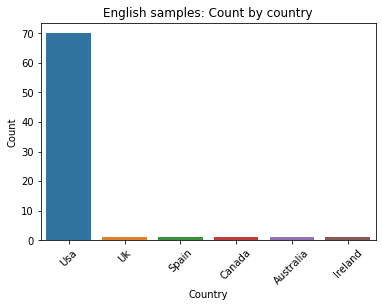

In [40]:
sns.countplot(x='country', data=eng_samples)
plt.title('English samples: Count by country')
plt.xlabel('Country')
plt.ylabel('Count')
plt.xticks(rotation=45)
#plt.savefig('{}EngCountrySampleDist.png'.format(FIG_PATH))

Text(0, 0.5, 'Count')

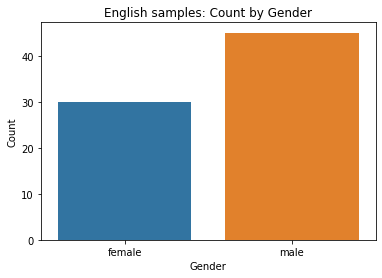

In [41]:
# Check that gender is still roughly distributed equally
sns.countplot(x='sex', data=eng_samples)
plt.title('English samples: Count by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
#plt.xticks(rotation=45)

### Split English files into training, validation and testing sets

In [42]:
eng_train_names, eng_test_names, eng_y_train, eng_y_test = train_test_split(
    eng_samples['filename'], eng_samples['sex'], test_size=0.25, random_state=38)

In [43]:
eng_train_names, eng_val_names, eng_y_train, eng_y_val = train_test_split(
    eng_train_names, eng_y_train, test_size = 0.25, random_state=38)

In [44]:
print("Number of training files: ", eng_train_names.shape)
print("Number of validation files: ", eng_val_names.shape)
print("Number of testing files: ", eng_test_names.shape)

Number of training files:  (42,)
Number of validation files:  (14,)
Number of testing files:  (19,)


### Segment the English files

In [45]:
# Check if TRAINING data has been segmented. If not, segment each audio file.
eng_train_list = os.listdir('{}/english'.format(L_TRAIN_DIR))

for i in range(len(eng_train_names)):
    # get a filename
    filename = eng_train_names.iloc[i]
    # Check to see if the filename has already been segmented
    if any(file.startswith(filename) for file in eng_train_list):
        pass
    else: 
        segment_audio(eng_train_names.iloc[i], eng_y_train.iloc[i], split='train/english', clf=CLF)
        #print('{} segmented'.format(filename))
print("English training segmentation complete")

English training segmentation complete


In [46]:
# Check how many segmented files there are (without noise)
# Returns a list of the filenames up to '.o.wav', which can be used to append the 'n.wav' later
eng_train_seg = [x.split('o.wav')[0] 
                 for x in os.listdir('{}/english'.format(L_TRAIN_DIR)) 
                 if x.endswith('o.wav')]
print(len(eng_train_seg))

77


In [47]:
eng_val_list = os.listdir('{}/english'.format(L_VAL_DIR))

for i in range(len(eng_val_names)):
    # get a filename
    filename = eng_val_names.iloc[i]
    # Check to see if the filename has already been segmented
    if any(file.startswith(filename) for file in eng_val_list):
        pass
    else: 
        segment_audio(eng_val_names.iloc[i], eng_y_val.iloc[i], split='validation/english', clf=CLF)
    #print('{} segmented'.format(filename))
print("English validation segmentation complete")

English validation segmentation complete


In [48]:
# Check how many segmented files there are (without noise)
# Returns a list of the filenames up to '.o.wav', which can be used to append the 'n.wav' later
eng_val_seg = [x.split('o.wav')[0] 
               for x in os.listdir('{}/english'.format(L_VAL_DIR)) 
               if x.endswith('o.wav')]
print(len(eng_val_seg))

24


In [49]:
# Check if TESTING data has been segmented. If not, segment each audio file.
eng_test_list = os.listdir('{}/test_data'.format(L_TEST_DIR))

for i in range(len(eng_test_names)):
    filename = eng_test_names.iloc[i]
    if any(file.startswith(filename) for file in eng_test_list):
        pass
    else: 
        segment_audio(eng_test_names.iloc[i], eng_y_test.iloc[i], split='test/test_data', clf=CLF)
        #print('{} segmented'.format(filename))
print("English testing segmentation complete")

English testing segmentation complete


In [50]:
# Check how many segmented files there are (without noise)
# Returns a list of the filenames up to '.o.wav', which can be used to append the 'n.wav' later
eng_test_seg = [x.split('o.wav')[0] 
                for x in os.listdir('{}/test_data'.format(L_TEST_DIR)) 
                if x.endswith('o.wav')]
print(len(eng_test_seg))

373


## Augment English testing and training data with noise

In [51]:
# Check if TRAINING data has been augmented with noise. If not, add noise to each segment.
eng_train = os.listdir('{}/english'.format(L_TRAIN_DIR))


for i in range(len(eng_train_seg)):
    filename = eng_train_seg[i]
    if any((file.startswith(filename)& file.endswith('n.wav')) for file in eng_train):
        pass
    else: 
        noisy_data(eng_train_seg[i], split='train/english', clf=CLF)
        #print('{} augmented'.format(filename))
print("Training augmentation complete")

Training augmentation complete


In [52]:
# Check if VALIDATION data has been augmented with noise. If not, add noise to each segment.
eng_val = os.listdir('{}/english'.format(L_VAL_DIR))

for i in range(len(eng_val_seg)):
    filename = eng_val_seg[i]
    if any((file.startswith(filename)& file.endswith('n.wav')) for file in eng_val):
        pass
    else: 
        noisy_data(eng_val_seg[i], split='validation/english', clf=CLF)
        #print('{} augmented'.format(filename))
print("Validition augmentation complete")

Validition augmentation complete


## Extract top 10 languages

In [53]:
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [54]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german']
all_lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'russian', 
             'portuguese', 'dutch', 'turkish', 'german', 'english']

## Split data by language and divide each language into train, val and test sets

In [55]:
# Extract Spanish data
spanish = meta.loc[meta.native_language == 'spanish']
# Downsample
spanish_samp = spanish.sample(75, replace=False, random_state=38)
# Split
spanish_train_names, spanish_test_names, spanish_y_train, spanish_y_test = train_test_split(
    spanish_samp['filename'], spanish_samp['sex'], test_size=0.25, random_state=38)
spanish_train_names, spanish_val_names, spanish_y_train, spanish_y_val = train_test_split(
    spanish_train_names, spanish_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", spanish_train_names.shape)
print("Number of training files: ", spanish_val_names.shape)
print("Number of testing files: ", spanish_test_names.shape)

Number of training files:  (42,)
Number of training files:  (14,)
Number of testing files:  (19,)


In [56]:
# Extract Arabic data
arabic = meta.loc[meta.native_language == 'arabic']
# Downsample
arabic_samp = arabic.sample(75, replace=False, random_state = 38)
# Split
arabic_train_names, arabic_test_names, arabic_y_train, arabic_y_test = train_test_split(
    arabic_samp['filename'], arabic_samp['sex'], test_size=0.25, random_state=38)
arabic_train_names, arabic_val_names, arabic_y_train, arabic_y_val = train_test_split(
    arabic_train_names, arabic_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", arabic_train_names.shape)
print("Number of training files: ", arabic_val_names.shape)
print("Number of testing files: ", arabic_test_names.shape)

Number of training files:  (42,)
Number of training files:  (14,)
Number of testing files:  (19,)


In [57]:
# Split Mandarin data
mandarin = meta.loc[meta.native_language == 'mandarin']
mandarin_train_names, mandarin_test_names, mandarin_y_train, mandarin_y_test = train_test_split(
    mandarin['filename'], mandarin['sex'], test_size=0.25, random_state=38)
mandarin_train_names, mandarin_val_names, mandarin_y_train, mandarin_y_val = train_test_split(
    mandarin_train_names, mandarin_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", mandarin_train_names.shape)
print("Number of training files: ", mandarin_val_names.shape)
print("Number of testing files: ", mandarin_test_names.shape)

Number of training files:  (36,)
Number of training files:  (12,)
Number of testing files:  (17,)


In [58]:
# Split French data
french = meta.loc[meta.native_language == 'french']
french_train_names, french_test_names, french_y_train, french_y_test = train_test_split(
    french['filename'], french['sex'], test_size=0.25, random_state=38)
french_train_names, french_val_names, french_y_train, french_y_val = train_test_split(
    french_train_names, french_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", french_train_names.shape)
print("Number of training files: ", french_val_names.shape)
print("Number of testing files: ", french_test_names.shape)

Number of training files:  (35,)
Number of training files:  (12,)
Number of testing files:  (16,)


In [59]:
# Split Korean data
korean = meta.loc[meta.native_language == 'korean']
korean_train_names, korean_test_names, korean_y_train, korean_y_test = train_test_split(
    korean['filename'], korean['sex'], test_size=0.25, random_state=38)
korean_train_names, korean_val_names, korean_y_train, korean_y_val = train_test_split(
    korean_train_names, korean_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", korean_train_names.shape)
print("Number of training files: ", korean_val_names.shape)
print("Number of testing files: ", korean_test_names.shape)

Number of training files:  (29,)
Number of training files:  (10,)
Number of testing files:  (13,)


In [60]:
# Split Russian data
russian = meta.loc[meta.native_language == 'russian']
russian_train_names, russian_test_names, russian_y_train, russian_y_test = train_test_split(
    russian['filename'], russian['sex'], test_size=0.25, random_state=38)
russian_train_names, russian_val_names, russian_y_train, russian_y_val = train_test_split(
    russian_train_names, russian_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", russian_train_names.shape)
print("Number of training files: ", russian_val_names.shape)
print("Number of testing files: ", russian_test_names.shape)

Number of training files:  (27,)
Number of training files:  (9,)
Number of testing files:  (12,)


In [61]:
# Split Portuguese data
portuguese = meta.loc[meta.native_language == 'portuguese']
portuguese_train_names, portuguese_test_names, portuguese_y_train, portuguese_y_test = train_test_split(
    portuguese['filename'], portuguese['sex'], test_size=0.25, random_state=38)
portuguese_train_names, portuguese_val_names, portuguese_y_train, portuguese_y_val = train_test_split(
    portuguese_train_names, portuguese_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", portuguese_train_names.shape)
print("Number of training files: ", portuguese_val_names.shape)
print("Number of testing files: ", portuguese_test_names.shape)

Number of training files:  (27,)
Number of training files:  (9,)
Number of testing files:  (12,)


In [62]:
# Split Dutch data
dutch = meta.loc[meta.native_language == 'dutch']
dutch_train_names, dutch_test_names, dutch_y_train, dutch_y_test = train_test_split(
    dutch['filename'], dutch['sex'], test_size=0.25, random_state=38)
dutch_train_names, dutch_val_names, dutch_y_train, dutch_y_val = train_test_split(
    dutch_train_names, dutch_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", dutch_train_names.shape)
print("Number of training files: ", dutch_val_names.shape)
print("Number of testing files: ", dutch_test_names.shape)

Number of training files:  (26,)
Number of training files:  (9,)
Number of testing files:  (12,)


In [63]:
# Split Turkish data
turkish = meta.loc[meta.native_language == 'turkish']
turkish_train_names, turkish_test_names, turkish_y_train, turkish_y_test = train_test_split(
    turkish['filename'], turkish['sex'], test_size=0.25, random_state=38)
turkish_train_names, turkish_val_names, turkish_y_train, turkish_y_val = train_test_split(
    turkish_train_names, turkish_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", turkish_train_names.shape)
print("Number of training files: ", turkish_val_names.shape)
print("Number of testing files: ", turkish_test_names.shape)

Number of training files:  (20,)
Number of training files:  (7,)
Number of testing files:  (10,)


In [64]:
# Split German data
german = meta.loc[meta.native_language == 'german']
german_train_names, german_test_names, german_y_train, german_y_test = train_test_split(
    german['filename'], german['sex'], test_size=0.25, random_state=38)
german_train_names, german_val_names, german_y_train, german_y_val = train_test_split(
    german_train_names, german_y_train, test_size = 0.25, random_state=38)
print("Number of training files: ", german_train_names.shape)
print("Number of training files: ", german_val_names.shape)
print("Number of testing files: ", german_test_names.shape)

Number of training files:  (20,)
Number of training files:  (7,)
Number of testing files:  (9,)


## Combine metadata about sampled speakers
Since English, Spanish and Arabic have been downsampled, include only metadata about the speakers used.

In [65]:
frames = [eng_samples, spanish_samp, arabic_samp, mandarin, french, korean, 
          russian, portuguese, dutch, turkish, german]
samples_df = pd.concat(frames)
samples_df['native_language'] = samples_df['native_language'].str.capitalize()
samples_df['native_language'].value_counts(normalize=True)

Spanish       0.120773
Arabic        0.120773
English       0.120773
Mandarin      0.104670
French        0.101449
Korean        0.083736
Portuguese    0.077295
Russian       0.077295
Dutch         0.075684
Turkish       0.059581
German        0.057971
Name: native_language, dtype: float64

Text(0, 0.5, 'Count')

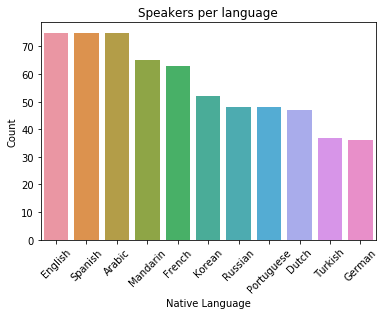

In [66]:
sns.countplot(x='native_language', data=samples_df)
plt.title('Speakers per language')
plt.xticks(rotation=45)
plt.xlabel('Native Language')
plt.ylabel('Count')
#plt.savefig('storage/figures/lang10/LanguageDist.png')

In [67]:
train_list = [spanish_train_names, arabic_train_names, mandarin_train_names, french_train_names, korean_train_names, 
             russian_train_names, portuguese_train_names, dutch_train_names, turkish_train_names, german_train_names]

y_train_list = [spanish_y_train, arabic_y_train, mandarin_y_train, french_y_train, korean_y_train, 
             russian_y_train, portuguese_y_train, dutch_y_train, turkish_y_train, german_y_train]

for lang, train, y_train in zip(lang_list, train_list, y_train_list):
    # Check if training data has been segmented. If not, segment each audio file.
    train_file_list = os.listdir('{}/{}'.format(L_TRAIN_DIR,lang))

    for i in range(len(train)):
        # get a filename
        filename = train.iloc[i]
        # Check to see if the filename has already been segmented
        if any(file.startswith(filename) for file in train_file_list):
              pass
        else: 
            segment_audio(train.iloc[i], y_train.iloc[i], split='train/{}'.format(lang), clf=CLF)
            #print('{} segmented'.format(filename))
print('Training segmentation complete')

Training segmentation complete


In [68]:
val_list = [spanish_val_names, arabic_val_names, mandarin_val_names, french_val_names, korean_val_names, 
             russian_val_names, portuguese_val_names, dutch_val_names, turkish_val_names, german_val_names]

y_val_list = [spanish_y_val, arabic_y_val, mandarin_y_val, french_y_val, korean_y_val, 
             russian_y_val, portuguese_y_val, dutch_y_val, turkish_y_val, german_y_val]

for lang, val, y_val in zip(lang_list, val_list, y_val_list):
    # Check if training data has been segmented. If not, segment each audio file.
    val_file_list = os.listdir('{}/{}'.format(L_VAL_DIR, lang))

    for i in range(len(val)):
        # get a filename
        filename = val.iloc[i]
        # Check to see if the filename has already been segmented
        if any(file.startswith(filename) for file in val_file_list):
            pass
        else: 
            segment_audio(val.iloc[i], y_val.iloc[i], split='validation/{}'.format(lang), clf=CLF)
            #print('{} segmented'.format(filename))
            
print('Validation segmentation complete')

Validation segmentation complete


In [69]:
test_list = [spanish_test_names, arabic_test_names, mandarin_test_names, french_test_names, korean_test_names, 
             russian_test_names, portuguese_test_names, dutch_test_names, turkish_test_names, german_test_names]

y_test_list = [spanish_y_test, arabic_y_test, mandarin_y_test, french_y_test, korean_y_test, 
             russian_y_test, portuguese_y_test, dutch_y_test, turkish_y_test, german_y_test]

for lang, test, y_test in zip(lang_list, test_list, y_test_list):
    # Check if training data has been segmented. If not, segment each audio file.
    test_file_list = os.listdir('{}/test_data'.format(L_TEST_DIR))

    for i in range(len(test)):
        # get a filename
        filename = test.iloc[i]
        # Check to see if the filename has already been segmented
        if any(file.startswith(filename) for file in test_file_list):
            pass
        else: 
            segment_audio(test.iloc[i], y_test.iloc[i], split='test/test_data', clf=CLF)
            #print('{} segmented'.format(filename))

print('Testing segementation complete')

Testing segementation complete


In [70]:
# Generate a list training filenames + segment index to input to add_noise() function
train_dict = {}
val_dict = {}

for lang in all_lang_list:
    train_dict[lang] = [x.split('o.wav')[0] 
                        for x in os.listdir('{}/{}'.format(L_TRAIN_DIR, lang)) 
                        if x.endswith('o.wav')]
    val_dict[lang] = [x.split('o.wav')[0] 
                      for x in os.listdir('{}/{}'.format(L_VAL_DIR, lang))
                      if x.endswith('o.wav')]

In [71]:
# Check if training data has been augmented with noise. If not, add noise to each segment.
for key, val in train_dict.items():
    noise_train_list = os.listdir('{}/{}'.format(L_TRAIN_DIR, key))
    for i in range(len(val)):
        filename = val[i]
        if any((file.startswith(filename)& file.endswith('n.wav')) for file in noise_train_list):
            pass
        else: 
            noisy_data(val[i], split='train/{}'.format(key), clf=CLF)

In [72]:
# Check if validation data has been augmented with noise. If not, add noise to each segment.
for key, val in val_dict.items():
    noise_val_list = os.listdir('{}/{}'.format(L_VAL_DIR, key))
    for i in range(len(val)):
        filename = val[i]
        if any((file.startswith(filename)& file.endswith('n.wav')) for file in noise_val_list):
            pass
        else: 
            noisy_data(val[i], split='validation/{}'.format(key), clf=CLF)

# Summary of speakers and samples
The speakers were divided into training and testing sets before the audio files were segemented. I expect that the proportion of speakers per class will be similar to the proportion of samples per class, but I should check that.

I would like to know the number of speakers per class and number of samples per class for each of the training, validation and testing datasets.

In [73]:
# Number of speakers per language in the datasets
n_train_speakers = {}
n_val_speakers = {}
n_test_speakers = {}

# Add English speaker counts
n_train_speakers['english'] = eng_train_names.shape[0]
n_val_speakers['english'] = eng_val_names.shape[0]
n_test_speakers['english'] = eng_test_names.shape[0]

for lang, train, val, test in zip(lang_list, train_list, val_list, test_list):
    n_train_speakers[lang] = train.shape[0]
    n_val_speakers[lang] = val.shape[0]
    n_test_speakers[lang] = test.shape[0]

In [74]:
languages = os.listdir(L_TRAIN_DIR)
languages.remove('.DS_Store')

train_seg_dict = {}
val_seg_dict = {}
for lang in all_lang_list:
    train_seg_dict[lang] = len([ x for x 
                                in os.listdir('{}/{}'.format(L_TRAIN_DIR, lang))
                                if x.endswith('.wav')])
    val_seg_dict[lang] = len([ x for x 
                              in os.listdir('{}/{}'.format(L_VAL_DIR, lang))
                              if x.endswith('.wav')])

In [75]:
test_seg_dict={}
for file in os.listdir('{}/test_data'.format(L_TEST_DIR)):
    lang = file.split('.')[0].rstrip('0123456789')
    if lang in test_seg_dict.keys():
        test_seg_dict[lang] += 1
    else: test_seg_dict[lang] = 1

In [76]:
lang_seg_dict = {"Train": train_seg_dict, "Val": val_seg_dict, "Test":test_seg_dict}

lang_seg = pd.DataFrame(lang_seg_dict)
lang_seg.sort_values(by='Train', inplace=True, ascending=False)

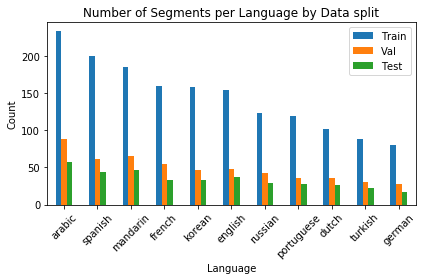

In [77]:
lang_seg.plot.bar()
plt.title('Number of Segments per Language by Data split')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Language')
plt.tight_layout()
#plt.savefig('Lang.SpeakerDatasetbyLang.png')

In [78]:
lang_seg_melt = pd.melt(lang_seg.reset_index(), id_vars=['index'], 
                    value_vars=['Train', 'Val', 'Test'],
                   var_name='dataset', value_name='n_seg')

In [79]:
lang_sp_dict = {"Train": n_train_speakers, "Val": n_val_speakers, "Test": n_test_speakers}

lang_sp = pd.DataFrame(lang_sp_dict)
lang_sp.sort_values(by='Train', inplace=True, ascending=False)

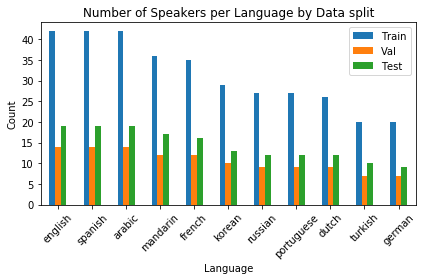

In [80]:
lang_sp.plot.bar()
plt.title('Number of Speakers per Language by Data split')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.xlabel('Language')
plt.tight_layout()
#plt.savefig('Lang.SpeakerDatasetbyLang.png')

In [81]:
lang_sp_melt = pd.melt(lang_sp.reset_index(), id_vars=['index'], 
                    value_vars=['Train', 'Val', 'Test'],
                   var_name='dataset', value_name='n_sp')

In [82]:
lang_split = pd.merge(lang_seg_melt,lang_sp_melt, how='outer', on=['index', 'dataset'])
lang_split.head()

,index,dataset,n_seg,n_sp
0,arabic,Train,234,42
1,spanish,Train,200,42
2,mandarin,Train,186,36
3,french,Train,160,35
4,korean,Train,158,29


In [83]:
lang_split.to_csv('{}data/lang10/data_split_summary.csv'.format(root_dir))

# Comments
At this point, all of the audio files have been split into training, validation and testing sets. All of the audio files have been segmented into 10s segments and noise has been added to the training and validation sets.

The next notebooks (3_ktr_GenderModels, 4_ktr_LanguageModels) will format the data into tensorflow datasets, and build and train classifier models.